In [1]:
%matplotlib inline


# Early stopping of Stochastic Gradient Descent


Stochastic Gradient Descent is an optimization technique which minimizes a loss
function in a stochastic fashion, performing a gradient descent step sample by
sample. In particular, it is a very efficient method to fit linear models.

As a stochastic method, the loss function is not necessarily decreasing at each
iteration, and convergence is only guaranteed in expectation. For this reason,
monitoring the convergence on the loss function can be difficult.

Another approach is to monitor convergence on a validation score. In this case,
the input data is split into a training set and a validation set. The model is
then fitted on the training set and the stopping criterion is based on the
prediction score computed on the validation set. This enables us to find the
least number of iterations which is sufficient to build a model that
generalizes well to unseen data and reduces the chance of over-fitting the
training data.

This early stopping strategy is activated if ``early_stopping=True``; otherwise
the stopping criterion only uses the training loss on the entire input data. To
better control the early stopping strategy, we can specify a parameter
``validation_fraction`` which set the fraction of the input dataset that we
keep aside to compute the validation score. The optimization will continue
until the validation score did not improve by at least ``tol`` during the last
``n_iter_no_change`` iterations. The actual number of iterations is available
at the attribute ``n_iter_``.

This example illustrates how the early stopping can used in the
:class:`sklearn.linear_model.SGDClassifier` model to achieve almost the same
accuracy as compared to a model built without early stopping. This can
significantly reduce training time. Note that scores differ between the
stopping criteria even from early iterations because some of the training data
is held out with the validation stopping criterion.



Automatically created module for IPython interactive environment
No stopping criterion: .................................................
Training loss: .................................................
Validation score: .................................................


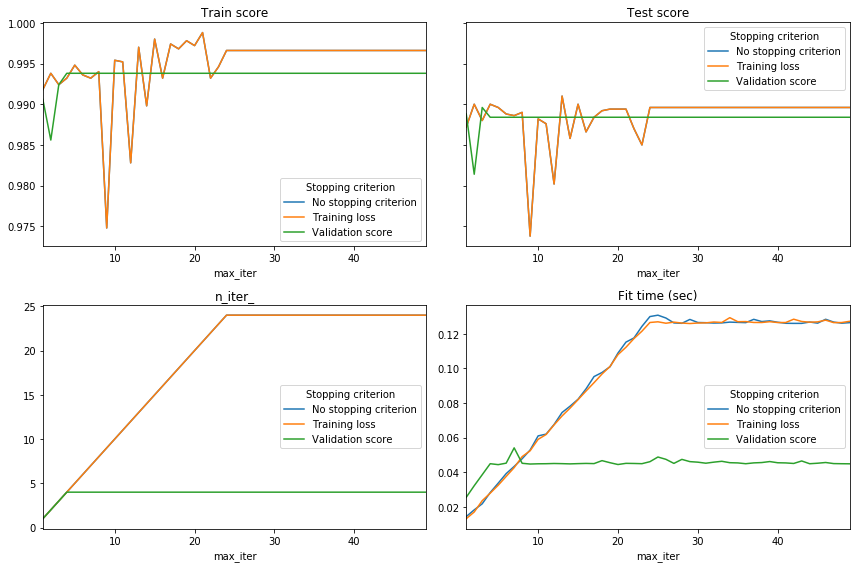

In [3]:
# Authors: Tom Dupre la Tour
#
# License: BSD 3 clause
import time
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import shuffle

print(__doc__)


def load_mnist(n_samples=None, class_0='0', class_1='8'):
    """Load MNIST, select two classes, shuffle and return only n_samples."""
    # Load data from http://openml.org/d/554
    mnist = fetch_openml('mnist_784', version=1)

    # take only two classes for binary classification
    mask = np.logical_or(mnist.target == class_0, mnist.target == class_1)

    X, y = shuffle(mnist.data[mask], mnist.target[mask], random_state=42)
    if n_samples is not None:
        X, y = X[:n_samples], y[:n_samples]
    return X, y


@ignore_warnings(category=ConvergenceWarning)
def fit_and_score(estimator, max_iter, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.set_params(max_iter=max_iter)
    estimator.set_params(random_state=0)

    start = time.time()
    estimator.fit(X_train, y_train)

    fit_time = time.time() - start
    n_iter = estimator.n_iter_
    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return fit_time, n_iter, train_score, test_score


# Define the estimators to compare
estimator_dict = {
    'No stopping criterion':
    linear_model.SGDClassifier(tol=1e-3, n_iter_no_change=3),
    'Training loss':
    linear_model.SGDClassifier(early_stopping=False, n_iter_no_change=3,
                               tol=0.1),
    'Validation score':
    linear_model.SGDClassifier(early_stopping=True, n_iter_no_change=3,
                               tol=0.0001, validation_fraction=0.2)
}

# Load the dataset
X, y = load_mnist(n_samples=10000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=0)

results = []
for estimator_name, estimator in estimator_dict.items():
    print(estimator_name + ': ', end='')
    for max_iter in range(1, 50):
        print('.', end='')
        sys.stdout.flush()

        fit_time, n_iter, train_score, test_score = fit_and_score(
            estimator, max_iter, X_train, X_test, y_train, y_test)

        results.append((estimator_name, max_iter, fit_time, n_iter,
                        train_score, test_score))
    print('')

# Transform the results in a pandas dataframe for easy plotting
columns = [
    'Stopping criterion', 'max_iter', 'Fit time (sec)', 'n_iter_',
    'Train score', 'Test score'
]
results_df = pd.DataFrame(results, columns=columns)

# Define what to plot (x_axis, y_axis)
lines = 'Stopping criterion'
plot_list = [
    ('max_iter', 'Train score'),
    ('max_iter', 'Test score'),
    ('max_iter', 'n_iter_'),
    ('max_iter', 'Fit time (sec)'),
]

nrows = 2
ncols = int(np.ceil(len(plot_list) / 2.))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols,
                                                            4 * nrows))
axes[0, 0].get_shared_y_axes().join(axes[0, 0], axes[0, 1])

for ax, (x_axis, y_axis) in zip(axes.ravel(), plot_list):
    for criterion, group_df in results_df.groupby(lines):
        group_df.plot(x=x_axis, y=y_axis, label=criterion, ax=ax)
    ax.set_title(y_axis)
    ax.legend(title=lines)

fig.tight_layout()
plt.show()